# Tutorial 06

## fitting pipeline pre-process

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
NSAMP = 10
APOSCALE = 6.
PSBIN = 30
LMIN = 30
LMAX = 210
FWHM = [np.deg2rad(52.8/60.),np.deg2rad(19./60.),np.deg2rad(11./60.),np.deg2rad(4.94/60.)]

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])
mapcmb = np.empty((NSAMP,3,map23f.shape[1]),dtype=np.float32)
for i in range(NSAMP):
    mapcmb[i] = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

vmap23 = hp.read_map('./data/wmapvar_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap23 = np.random.normal(0.,1.,size=(NSAMP,3,vmap23.shape[1]))*np.sqrt(vmap23)
nmap95 = np.random.normal(0.,1.,size=(NSAMP,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP,3,vmap150.shape[1]))*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=(NSAMP,3,vmap353.shape[1]))*np.sqrt(vmap353)

map23 = hp.smoothing(mapcmb[0]+map23f,fwhm=FWHM[0],verbose=0)+nmap23[0]
map95 = hp.smoothing(mapcmb[0]+map95f,fwhm=FWHM[1],verbose=0)+nmap95[0]
map150 = hp.smoothing(mapcmb[0]+map150f,fwhm=FWHM[2],verbose=0)+nmap150[0]
map353 = hp.smoothing(mapcmb[0]+map353f,fwhm=FWHM[3],verbose=0)+nmap353[0]

map23s = hp.smoothing(mapcmb[0]+map23f,fwhm=FWHM[0],verbose=0)
map95s = hp.smoothing(mapcmb[0]+map95f,fwhm=FWHM[1],verbose=0)
map150s = hp.smoothing(mapcmb[0]+map150f,fwhm=FWHM[2],verbose=0)
map353s = hp.smoothing(mapcmb[0]+map353f,fwhm=FWHM[3],verbose=0)

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### window function matrix (top-hat according to NaMaster)

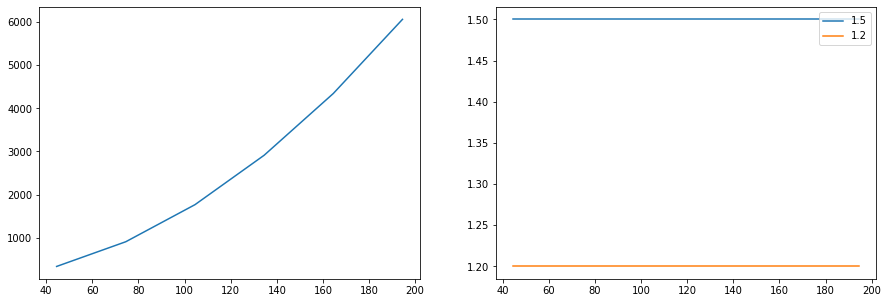

In [2]:
from afra.tools.ps_estimator import pstimator

est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,targets='EB')
window = est.bpconvert(np.ones(LMAX+1-LMIN))

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(est.modes,window)

filtee = np.identity(len(est.modes))
filtbb = np.identity(len(est.modes))
filteb = 0.5*np.identity(len(est.modes))
filtbe = 0.2*np.identity(len(est.modes))

est.filt = {'EB': np.c_[np.r_[filtee,filtbe],np.r_[filteb,filtbb]]}
filted_bp = est.filtrans(np.ones((2,len(est.modes))))

ax[1].plot(est.modes,filted_bp[0],label='1.5')
ax[1].plot(est.modes,filted_bp[1],label='1.2')
ax[1].legend(loc=1)

#### pipeline pre-process

- T mode

attributes assigned:

- data_bp: measurement band-power matrix
- noise_bp: noises band-power matrix
- ndata_bp: measurement+noise band-power matrix
- fiducial_bp: fiducial band-power matrix
- nfiducial_bp: fiducial+noise band-power matrix
- template_bp: template auto corr. band-power dict

In [3]:
%%time

datamap = {95:mapcmb[0],353:mapcmb[0]}
datanoise = {95:nmap95,353:nmap353}

fidmap = {95:mapcmb,353:mapcmb}

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pp = af.pipe(datamap,noises=datanoise,mask=mask,
             fiducials=fidmap,
             templates=tmpmap,template_noises=tmpnoise,template_beams=tmpbeam,
             targets='T')
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

CPU times: user 44.5 s, sys: 216 ms, total: 44.7 s
Wall time: 5.78 s


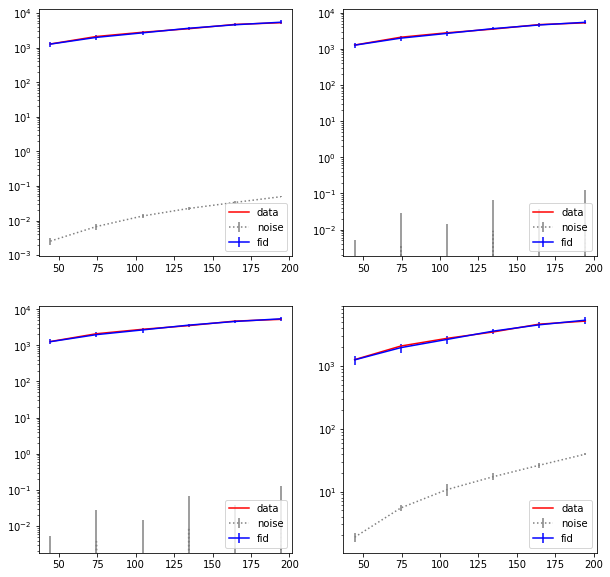

In [4]:
modes = pp.estimator.modes
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)
ax1.plot(modes,pp.data_bp[0,:,0,0],label='data',c='red')
ax1.errorbar(modes,np.mean(pp.noise_bp[:,0,:,0,0],axis=0),
             2*np.std(pp.noise_bp[:,0,:,0,0],axis=0),label='noise',c='grey',ls=':')
ax1.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,0,0],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,0,0],axis=0),label='fid',c='blue')
ax1.set_yscale('log')
ax1.legend(loc=4)

ax2 = fig.add_subplot(222)
ax2.plot(modes,pp.data_bp[0,:,0,1],label='data',c='red')
ax2.errorbar(modes,np.mean(pp.noise_bp[:,0,:,0,1],axis=0),
             2*np.std(pp.noise_bp[:,0,:,0,1],axis=0),label='noise',c='grey',ls=':')
ax2.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,0,1],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,0,1],axis=0),label='fid',c='blue')
ax2.set_yscale('log')
ax2.legend(loc=4)

ax3 = fig.add_subplot(223)
ax3.plot(modes,pp.data_bp[0,:,1,0],label='data',c='red')
ax3.errorbar(modes,np.mean(pp.noise_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.noise_bp[:,0,:,1,0],axis=0),label='noise',c='grey',ls=':')
ax3.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,1,0],axis=0),label='fid',c='blue')
ax3.set_yscale('log')
ax3.legend(loc=4)

ax4 = fig.add_subplot(224)
ax4.plot(modes,pp.data_bp[0,:,1,1],label='data',c='red')
ax4.errorbar(modes,np.mean(pp.noise_bp[:,0,:,1,1],axis=0),
             2*np.std(pp.noise_bp[:,0,:,1,1],axis=0),label='noise',c='grey',ls=':')
ax4.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,1,1],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,1,1],axis=0),label='fid',c='blue')
ax4.set_yscale('log')
ax4.legend(loc=4)

- E mode

In [5]:
%%time

datamap = {95:mapcmb[0],353:mapcmb[0]}
datanoise = {95:nmap95,353:nmap353}

fidmap = {95:mapcmb,353:mapcmb}

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pp = af.pipe(datamap,noises=datanoise,mask=mask,
             fiducials=fidmap,
             templates=tmpmap,template_noises=tmpnoise,template_beams=tmpbeam,
             targets='E')
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

Emat = pp.covmat

CPU times: user 14min 54s, sys: 1.87 s, total: 14min 56s
Wall time: 1min 54s


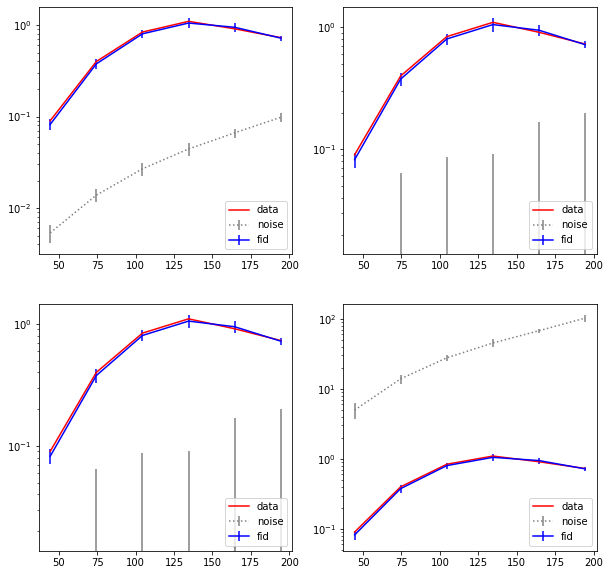

In [6]:
modes = pp.estimator.modes
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)
ax1.plot(modes,pp.data_bp[0,:,0,0],label='data',c='red')
ax1.errorbar(modes,np.mean(pp.noise_bp[:,0,:,0,0],axis=0),
             2*np.std(pp.noise_bp[:,0,:,0,0],axis=0),label='noise',c='grey',ls=':')
ax1.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,0,0],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,0,0],axis=0),label='fid',c='blue')
ax1.set_yscale('log')
ax1.legend(loc=4)

ax2 = fig.add_subplot(222)
ax2.plot(modes,pp.data_bp[0,:,0,1],label='data',c='red')
ax2.errorbar(modes,np.mean(pp.noise_bp[:,0,:,0,1],axis=0),
             2*np.std(pp.noise_bp[:,0,:,0,1],axis=0),label='noise',c='grey',ls=':')
ax2.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,0,1],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,0,1],axis=0),label='fid',c='blue')
ax2.set_yscale('log')
ax2.legend(loc=4)

ax3 = fig.add_subplot(223)
ax3.plot(modes,pp.data_bp[0,:,1,0],label='data',c='red')
ax3.errorbar(modes,np.mean(pp.noise_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.noise_bp[:,0,:,1,0],axis=0),label='noise',c='grey',ls=':')
ax3.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,1,0],axis=0),label='fid',c='blue')
ax3.set_yscale('log')
ax3.legend(loc=4)

ax4 = fig.add_subplot(224)
ax4.plot(modes,pp.data_bp[0,:,1,1],label='data',c='red')
ax4.errorbar(modes,np.mean(pp.noise_bp[:,0,:,1,1],axis=0),
             2*np.std(pp.noise_bp[:,0,:,1,1],axis=0),label='noise',c='grey',ls=':')
ax4.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,1,1],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,1,1],axis=0),label='fid',c='blue')
ax4.set_yscale('log')
ax4.legend(loc=4)

- B mode

In [7]:
%%time

datamap = {95:mapcmb[0],353:mapcmb[0]}
datanoise = {95:nmap95,353:nmap353}

fidmap = {95:mapcmb,353:mapcmb}

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pp = af.pipe(datamap,noises=datanoise,mask=mask,
             fiducials=fidmap,
             templates=tmpmap,template_noises=tmpnoise,template_beams=tmpbeam,
             targets='B')
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

Bmat = pp.covmat

CPU times: user 15min 5s, sys: 1.21 s, total: 15min 6s
Wall time: 1min 53s


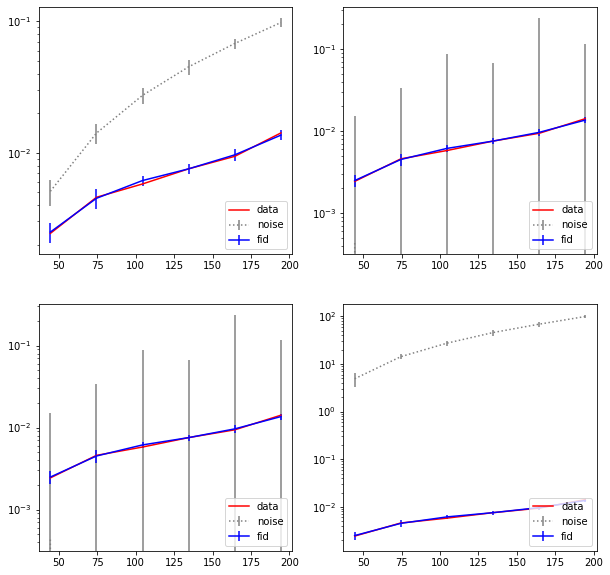

In [8]:
modes = pp.estimator.modes
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)
ax1.plot(modes,pp.data_bp[0,:,0,0],label='data',c='red')
ax1.errorbar(modes,np.mean(pp.noise_bp[:,0,:,0,0],axis=0),
             2*np.std(pp.noise_bp[:,0,:,0,0],axis=0),label='noise',c='grey',ls=':')
ax1.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,0,0],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,0,0],axis=0),label='fid',c='blue')
ax1.set_yscale('log')
ax1.legend(loc=4)

ax2 = fig.add_subplot(222)
ax2.plot(modes,pp.data_bp[0,:,0,1],label='data',c='red')
ax2.errorbar(modes,np.mean(pp.noise_bp[:,0,:,0,1],axis=0),
             2*np.std(pp.noise_bp[:,0,:,0,1],axis=0),label='noise',c='grey',ls=':')
ax2.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,0,1],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,0,1],axis=0),label='fid',c='blue')
ax2.set_yscale('log')
ax2.legend(loc=4)

ax3 = fig.add_subplot(223)
ax3.plot(modes,pp.data_bp[0,:,1,0],label='data',c='red')
ax3.errorbar(modes,np.mean(pp.noise_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.noise_bp[:,0,:,1,0],axis=0),label='noise',c='grey',ls=':')
ax3.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,1,0],axis=0),label='fid',c='blue')
ax3.set_yscale('log')
ax3.legend(loc=4)

ax4 = fig.add_subplot(224)
ax4.plot(modes,pp.data_bp[0,:,1,1],label='data',c='red')
ax4.errorbar(modes,np.mean(pp.noise_bp[:,0,:,1,1],axis=0),
             2*np.std(pp.noise_bp[:,0,:,1,1],axis=0),label='noise',c='grey',ls=':')
ax4.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,1,1],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,1,1],axis=0),label='fid',c='blue')
ax4.set_yscale('log')
ax4.legend(loc=4)

- E & B modes

In [9]:
%%time

datamap = {95:mapcmb[0],353:mapcmb[0]}
datanoise = {95:nmap95,353:nmap353}

fidmap = {95:mapcmb,353:mapcmb}

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pp = af.pipe(datamap,noises=datanoise,mask=mask,
             fiducials=fidmap,
             templates=tmpmap,template_noises=tmpnoise,template_beams=tmpbeam,
             targets='EB')
pp.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

EBmat = pp.covmat

CPU times: user 23min 54s, sys: 2.58 s, total: 23min 56s
Wall time: 3min


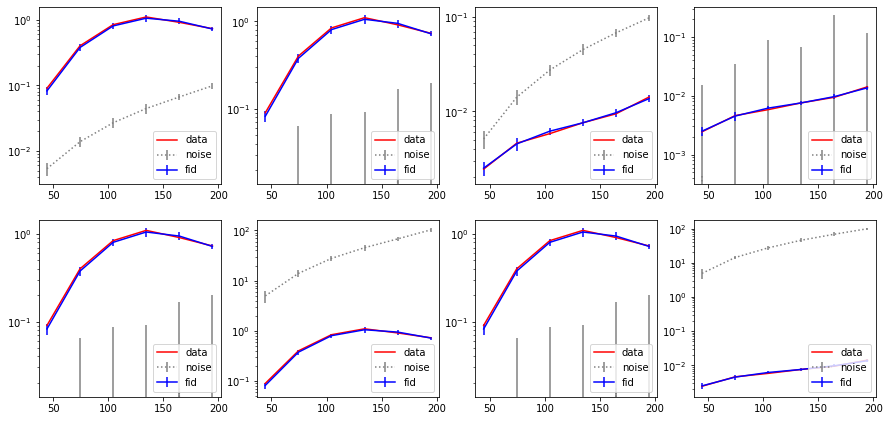

In [10]:
modes = pp.estimator.modes
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(441)
ax1.plot(modes,pp.data_bp[0,:,0,0],label='data',c='red')
ax1.errorbar(modes,np.mean(pp.noise_bp[:,0,:,0,0],axis=0),
             2*np.std(pp.noise_bp[:,0,:,0,0],axis=0),label='noise',c='grey',ls=':')
ax1.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,0,0],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,0,0],axis=0),label='fid',c='blue')
ax1.set_yscale('log')
ax1.legend(loc=4)

ax2 = fig.add_subplot(442)
ax2.plot(modes,pp.data_bp[0,:,0,1],label='data',c='red')
ax2.errorbar(modes,np.mean(pp.noise_bp[:,0,:,0,1],axis=0),
             2*np.std(pp.noise_bp[:,0,:,0,1],axis=0),label='noise',c='grey',ls=':')
ax2.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,0,1],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,0,1],axis=0),label='fid',c='blue')
ax2.set_yscale('log')
ax2.legend(loc=4)

ax1 = fig.add_subplot(443)
ax1.plot(modes,pp.data_bp[1,:,0,0],label='data',c='red')
ax1.errorbar(modes,np.mean(pp.noise_bp[:,1,:,0,0],axis=0),
             2*np.std(pp.noise_bp[:,1,:,0,0],axis=0),label='noise',c='grey',ls=':')
ax1.errorbar(modes,np.mean(pp.fiducial_bp[:,1,:,0,0],axis=0),
             2*np.std(pp.fiducial_bp[:,1,:,0,0],axis=0),label='fid',c='blue')
ax1.set_yscale('log')
ax1.legend(loc=4)

ax2 = fig.add_subplot(444)
ax2.plot(modes,pp.data_bp[1,:,0,1],label='data',c='red')
ax2.errorbar(modes,np.mean(pp.noise_bp[:,1,:,0,1],axis=0),
             2*np.std(pp.noise_bp[:,1,:,0,1],axis=0),label='noise',c='grey',ls=':')
ax2.errorbar(modes,np.mean(pp.fiducial_bp[:,1,:,0,1],axis=0),
             2*np.std(pp.fiducial_bp[:,1,:,0,1],axis=0),label='fid',c='blue')
ax2.set_yscale('log')
ax2.legend(loc=4)

ax3 = fig.add_subplot(445)
ax3.plot(modes,pp.data_bp[0,:,1,0],label='data',c='red')
ax3.errorbar(modes,np.mean(pp.noise_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.noise_bp[:,0,:,1,0],axis=0),label='noise',c='grey',ls=':')
ax3.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,1,0],axis=0),label='fid',c='blue')
ax3.set_yscale('log')
ax3.legend(loc=4)

ax4 = fig.add_subplot(446)
ax4.plot(modes,pp.data_bp[0,:,1,1],label='data',c='red')
ax4.errorbar(modes,np.mean(pp.noise_bp[:,0,:,1,1],axis=0),
             2*np.std(pp.noise_bp[:,0,:,1,1],axis=0),label='noise',c='grey',ls=':')
ax4.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,1,1],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,1,1],axis=0),label='fid',c='blue')
ax4.set_yscale('log')
ax4.legend(loc=4)

ax3 = fig.add_subplot(447)
ax3.plot(modes,pp.data_bp[0,:,1,0],label='data',c='red')
ax3.errorbar(modes,np.mean(pp.noise_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.noise_bp[:,0,:,1,0],axis=0),label='noise',c='grey',ls=':')
ax3.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,1,0],axis=0),label='fid',c='blue')
ax3.set_yscale('log')
ax3.legend(loc=4)

ax4 = fig.add_subplot(448)
ax4.plot(modes,pp.data_bp[1,:,1,1],label='data',c='red')
ax4.errorbar(modes,np.mean(pp.noise_bp[:,1,:,1,1],axis=0),
             2*np.std(pp.noise_bp[:,1,:,1,1],axis=0),label='noise',c='grey',ls=':')
ax4.errorbar(modes,np.mean(pp.fiducial_bp[:,1,:,1,1],axis=0),
             2*np.std(pp.fiducial_bp[:,1,:,1,1],axis=0),label='fid',c='blue')
ax4.set_yscale('log')
ax4.legend(loc=4)

- EB mode, reprocess

In [11]:
datamap = {95:mapcmb[1],353:mapcmb[1]}

pp.reprocess(datamap)

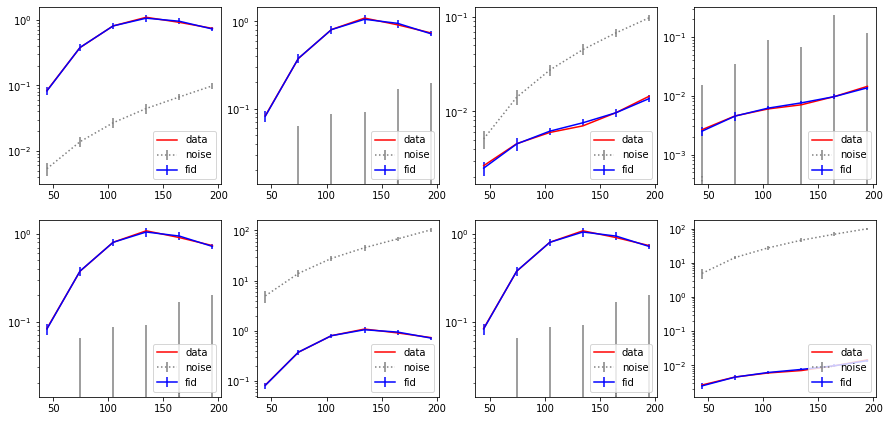

In [12]:
modes = pp.estimator.modes
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(441)
ax1.plot(modes,pp.data_bp[0,:,0,0],label='data',c='red')
ax1.errorbar(modes,np.mean(pp.noise_bp[:,0,:,0,0],axis=0),
             2*np.std(pp.noise_bp[:,0,:,0,0],axis=0),label='noise',c='grey',ls=':')
ax1.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,0,0],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,0,0],axis=0),label='fid',c='blue')
ax1.set_yscale('log')
ax1.legend(loc=4)

ax2 = fig.add_subplot(442)
ax2.plot(modes,pp.data_bp[0,:,0,1],label='data',c='red')
ax2.errorbar(modes,np.mean(pp.noise_bp[:,0,:,0,1],axis=0),
             2*np.std(pp.noise_bp[:,0,:,0,1],axis=0),label='noise',c='grey',ls=':')
ax2.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,0,1],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,0,1],axis=0),label='fid',c='blue')
ax2.set_yscale('log')
ax2.legend(loc=4)

ax1 = fig.add_subplot(443)
ax1.plot(modes,pp.data_bp[1,:,0,0],label='data',c='red')
ax1.errorbar(modes,np.mean(pp.noise_bp[:,1,:,0,0],axis=0),
             2*np.std(pp.noise_bp[:,1,:,0,0],axis=0),label='noise',c='grey',ls=':')
ax1.errorbar(modes,np.mean(pp.fiducial_bp[:,1,:,0,0],axis=0),
             2*np.std(pp.fiducial_bp[:,1,:,0,0],axis=0),label='fid',c='blue')
ax1.set_yscale('log')
ax1.legend(loc=4)

ax2 = fig.add_subplot(444)
ax2.plot(modes,pp.data_bp[1,:,0,1],label='data',c='red')
ax2.errorbar(modes,np.mean(pp.noise_bp[:,1,:,0,1],axis=0),
             2*np.std(pp.noise_bp[:,1,:,0,1],axis=0),label='noise',c='grey',ls=':')
ax2.errorbar(modes,np.mean(pp.fiducial_bp[:,1,:,0,1],axis=0),
             2*np.std(pp.fiducial_bp[:,1,:,0,1],axis=0),label='fid',c='blue')
ax2.set_yscale('log')
ax2.legend(loc=4)

ax3 = fig.add_subplot(445)
ax3.plot(modes,pp.data_bp[0,:,1,0],label='data',c='red')
ax3.errorbar(modes,np.mean(pp.noise_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.noise_bp[:,0,:,1,0],axis=0),label='noise',c='grey',ls=':')
ax3.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,1,0],axis=0),label='fid',c='blue')
ax3.set_yscale('log')
ax3.legend(loc=4)

ax4 = fig.add_subplot(446)
ax4.plot(modes,pp.data_bp[0,:,1,1],label='data',c='red')
ax4.errorbar(modes,np.mean(pp.noise_bp[:,0,:,1,1],axis=0),
             2*np.std(pp.noise_bp[:,0,:,1,1],axis=0),label='noise',c='grey',ls=':')
ax4.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,1,1],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,1,1],axis=0),label='fid',c='blue')
ax4.set_yscale('log')
ax4.legend(loc=4)

ax3 = fig.add_subplot(447)
ax3.plot(modes,pp.data_bp[0,:,1,0],label='data',c='red')
ax3.errorbar(modes,np.mean(pp.noise_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.noise_bp[:,0,:,1,0],axis=0),label='noise',c='grey',ls=':')
ax3.errorbar(modes,np.mean(pp.fiducial_bp[:,0,:,1,0],axis=0),
             2*np.std(pp.fiducial_bp[:,0,:,1,0],axis=0),label='fid',c='blue')
ax3.set_yscale('log')
ax3.legend(loc=4)

ax4 = fig.add_subplot(448)
ax4.plot(modes,pp.data_bp[1,:,1,1],label='data',c='red')
ax4.errorbar(modes,np.mean(pp.noise_bp[:,1,:,1,1],axis=0),
             2*np.std(pp.noise_bp[:,1,:,1,1],axis=0),label='noise',c='grey',ls=':')
ax4.errorbar(modes,np.mean(pp.fiducial_bp[:,1,:,1,1],axis=0),
             2*np.std(pp.fiducial_bp[:,1,:,1,1],axis=0),label='fid',c='blue')
ax4.set_yscale('log')
ax4.legend(loc=4)

- covariance matrix consistency check

<AxesSubplot:>

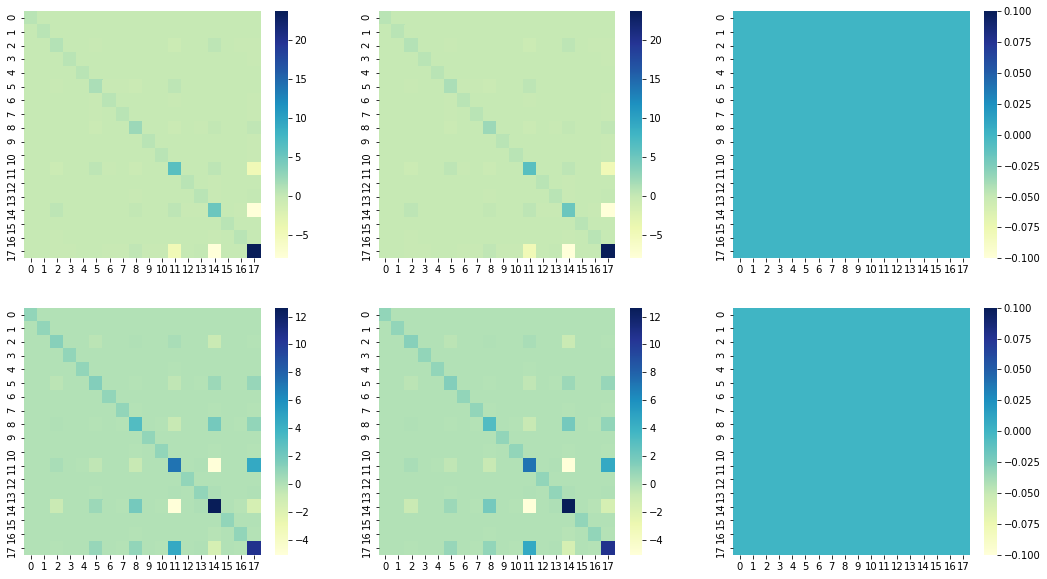

In [13]:
fig = plt.figure(figsize=(18,10))

ax = fig.add_subplot(231)
sns.heatmap(EBmat[:len(Emat),:len(Emat)],vmin=np.min(Emat),vmax=np.max(Emat),ax=ax,cmap="YlGnBu")

ax = fig.add_subplot(232)
sns.heatmap(Emat ,ax=ax,cmap="YlGnBu")

ax = fig.add_subplot(233)
sns.heatmap(EBmat[:len(Emat),:len(Emat)]-Emat,ax=ax,cmap="YlGnBu")

ax = fig.add_subplot(234)
sns.heatmap(EBmat[len(Bmat):,len(Bmat):],vmin=np.min(Bmat),vmax=np.max(Bmat),ax=ax,cmap="YlGnBu")

ax = fig.add_subplot(235)
sns.heatmap(Bmat ,ax=ax,cmap="YlGnBu")

ax = fig.add_subplot(236)
sns.heatmap(EBmat[len(Bmat):,len(Bmat):]-Bmat,ax=ax,cmap="YlGnBu")

end